In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"ayubkhan24mcs1047","key":"9db196b4d1d4317ac88a5e2d59c13938"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download the dataset
!kaggle competitions download -c m5-forecasting-accuracy

m5-forecasting-accuracy.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Unzip the file
!unzip m5-forecasting-accuracy.zip

Archive:  m5-forecasting-accuracy.zip
replace calendar.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: calendar.csv            
replace sales_train_evaluation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sales_train_evaluation.csv  
replace sales_train_validation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sales_train_validation.csv  
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace sell_prices.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sell_prices.csv         


In [5]:
# Install necessary libraries
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install scikit-learn
!pip install statsmodels
!pip install prophet
!pip install xgboost
!pip install lightgbm
!pip install tensorflow
!pip install joblib
!pip install scipy
!pip install streamlit

  Using cached streamlit-1.49.1-py3-none-any.whl.metadata (9.5 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached gitpython-3.1.45-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
Using cached streamlit-1.49.1-py3-none-any.whl (10.0 MB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached gitpython-3.1.45-py3-none-any.whl (208 kB)
Using cached pydeck-0.9.1-py2.py3-none-any.whl (6.9 MB)
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [6]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import xgboost as xgb # Added this import
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from scipy.optimize import minimize_scalar
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("All libraries loaded successfully ✅")

All libraries loaded successfully ✅


In [7]:
# Define paths
DATA_DIR = "/content"

# Load CSVs
sales = pd.read_csv(f"{DATA_DIR}/sales_train_validation.csv")
calendar = pd.read_csv(f"{DATA_DIR}/calendar.csv")
prices = pd.read_csv(f"{DATA_DIR}/sell_prices.csv")

print("Sales:", sales.shape)
print("Calendar:", calendar.shape)
print("Prices:", prices.shape)

display(sales.head())
display(calendar.head())
display(prices.head())


Sales: (30490, 1919)
Calendar: (1969, 14)
Prices: (6841121, 4)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [8]:
id_cols = ['id','item_id','dept_id','cat_id','store_id','state_id']
value_vars = [c for c in sales.columns if c.startswith('d_')]

sales_long = sales.melt(
    id_vars=id_cols,
    value_vars=value_vars,
    var_name='d',
    value_name='sales'
)
print("Sales long format shape:", sales_long.shape)
display(sales_long.head())


Sales long format shape: (58327370, 8)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [9]:
# Merge calendar info
merged_data = sales_long.merge(
    calendar[['d','date','wm_yr_wk','event_name_1','event_type_1']],
    on='d', how='left'
)

# Merge price info
merged_data = merged_data.merge(
    prices, on=['store_id','item_id','wm_yr_wk'], how='left'
)

print("Merged data shape:", merged_data.shape)
display(merged_data.head())


Merged data shape: (58327370, 13)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,event_name_1,event_type_1,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN


In [10]:
# Convert date column
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Create lag features
merged_data['lag_7'] = merged_data.groupby('id')['sales'].shift(7)
merged_data['lag_28'] = merged_data.groupby('id')['sales'].shift(28)

# Rolling mean features
merged_data['rolling_mean_7'] = merged_data.groupby('id')['sales'].shift(7).rolling(7).mean()

# Calendar-based features
merged_data['dayofweek'] = merged_data['date'].dt.dayofweek
merged_data['month'] = merged_data['date'].dt.month
merged_data['year'] = merged_data['date'].dt.year
merged_data['week'] = merged_data['date'].dt.isocalendar().week.astype(int)

# Drop rows with NaN lag values
merged_data.dropna(inplace=True)

print("Final shape after feature engineering:", merged_data.shape)
merged_data.head()


Final shape after feature engineering: (3649097, 20)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,event_name_1,event_type_1,sell_price,lag_7,lag_28,rolling_mean_7,dayofweek,month,year,week
1189113,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_40,0,2011-03-09,11106,LentStart,Religious,4.34,0.0,0.0,0.285714,2,3,2011,10
1189117,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_40,0,2011-03-09,11106,LentStart,Religious,0.42,0.0,2.0,0.000000,2,3,2011,10
1189118,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_40,0,2011-03-09,11106,LentStart,Religious,1.56,0.0,3.0,0.000000,2,3,2011,10
1189119,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_40,0,2011-03-09,11106,LentStart,Religious,3.17,0.0,0.0,0.000000,2,3,2011,10
1189121,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,d_40,2,2011-03-09,11106,LentStart,Religious,5.98,0.0,2.0,0.000000,2,3,2011,10


In [11]:
merged_data.to_csv("final_preprocessed_data.csv", index=False)
print("Preprocessed dataset saved successfully! ✅")


Preprocessed dataset saved successfully! ✅


In [12]:
cut_date = '2016-03-20' # Changed cut_date to create a non-empty validation set
train = merged_data[merged_data['date'] <= cut_date]
valid = merged_data[merged_data['date'] > cut_date]

print("Train shape:", train.shape)
print("Validation shape:", valid.shape)

Train shape: (3588117, 20)
Validation shape: (60980, 20)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy3y3dkv2/w8gulwh5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy3y3dkv2/65a3sh6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34737', 'data', 'file=/tmp/tmpy3y3dkv2/w8gulwh5.json', 'init=/tmp/tmpy3y3dkv2/65a3sh6n.json', 'output', 'file=/tmp/tmpy3y3dkv2/prophet_modelj2lxdpsb/prophet_model-20250914150344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:03:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:03:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


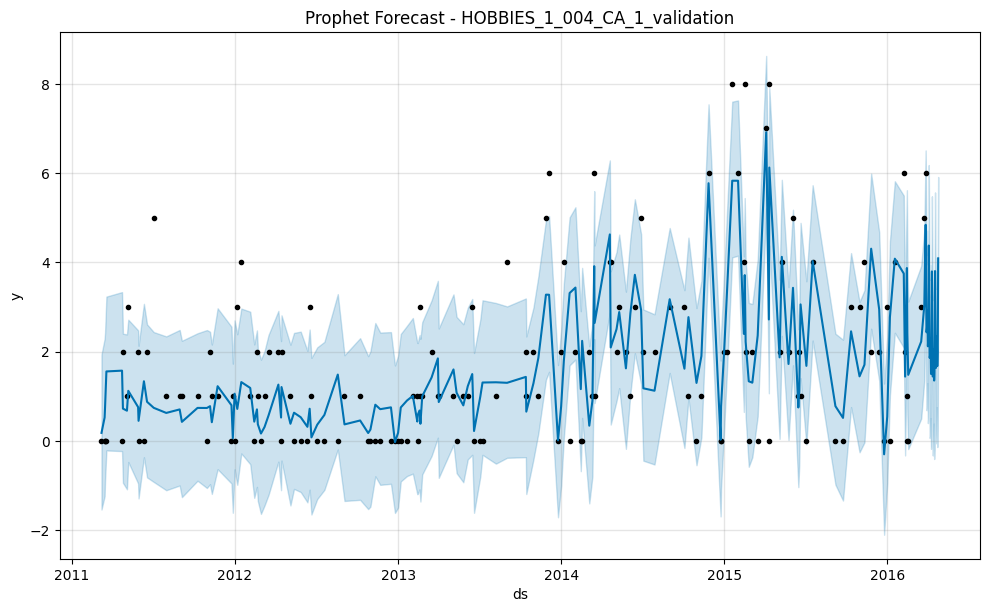

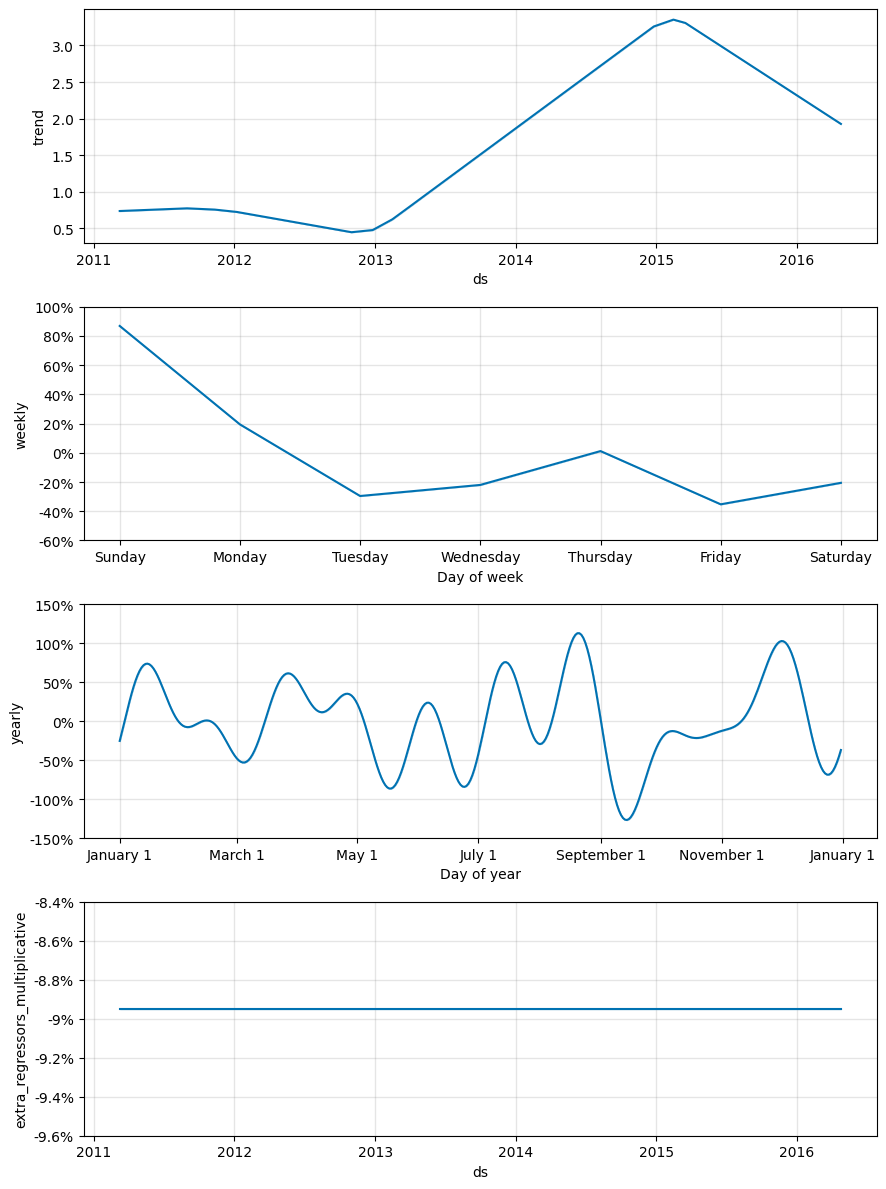

In [32]:
# Select a sample product
sample_id = merged_data['id'].iloc[0]
sample_df = merged_data[merged_data['id'] == sample_id][['date', 'sales', 'sell_price']]

# Prophet requires 'ds' and 'y'
prophet_df = sample_df.rename(columns={'date': 'ds', 'sales': 'y'})

# Initialize Prophet
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=10.0
)

# Add price as an extra regressor
prophet_model.add_regressor('sell_price')

# Fit
prophet_model.fit(prophet_df)

# Forecast 28 future days
future = prophet_model.make_future_dataframe(periods=28)
future['sell_price'] = sample_df['sell_price'].iloc[-1]  # assume constant price

forecast = prophet_model.predict(future)

# Plot forecast
prophet_model.plot(forecast)
plt.title(f"Prophet Forecast - {sample_id}")
plt.show()

# Components
prophet_model.plot_components(forecast)
plt.show()


In [33]:
# Encode categorical features
cat_cols = ['item_id','store_id','dept_id','cat_id']
for c in cat_cols:
    le = LabelEncoder()
    merged_data[c] = le.fit_transform(merged_data[c])

features = ['lag_7', 'lag_28', 'rolling_mean_7', 'dayofweek', 'month', 'sell_price'] + cat_cols

X_train = train[features]
y_train = train['sales']
X_valid = valid[features]
y_valid = valid['sales']

# Convert to DMatrix for xgboost.train
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)


In [34]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 8,
    'tree_method': 'hist'  # Change to 'gpu_hist' for GPU
}

evals = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=10
)

# Predictions
xgb_preds = xgb_model.predict(dvalid)

mae = mean_absolute_error(y_valid, xgb_preds)
rmse = np.sqrt(mean_squared_error(y_valid, xgb_preds))
print(f"XGBoost Performance → MAE: {mae:.2f}, RMSE: {rmse:.2f}")


[0]	train-rmse:4.18247	valid-rmse:3.71511
[10]	train-rmse:3.34828	valid-rmse:2.94369
[20]	train-rmse:2.96663	valid-rmse:2.58451
[30]	train-rmse:2.79563	valid-rmse:2.42985
[40]	train-rmse:2.71058	valid-rmse:2.35624
[50]	train-rmse:2.66422	valid-rmse:2.32192
[60]	train-rmse:2.63216	valid-rmse:2.30507
[70]	train-rmse:2.60848	valid-rmse:2.29674
[80]	train-rmse:2.58911	valid-rmse:2.29040
[90]	train-rmse:2.57344	valid-rmse:2.28506
[100]	train-rmse:2.56220	valid-rmse:2.28394
[110]	train-rmse:2.55303	valid-rmse:2.28422
[120]	train-rmse:2.54632	valid-rmse:2.28202
[130]	train-rmse:2.53634	valid-rmse:2.28004
[140]	train-rmse:2.53213	valid-rmse:2.28001
[150]	train-rmse:2.52522	valid-rmse:2.27904
[160]	train-rmse:2.51476	valid-rmse:2.28239
[170]	train-rmse:2.50502	valid-rmse:2.28192
[180]	train-rmse:2.49766	valid-rmse:2.28382
[182]	train-rmse:2.49557	valid-rmse:2.28287
XGBoost Performance → MAE: 1.10, RMSE: 2.28


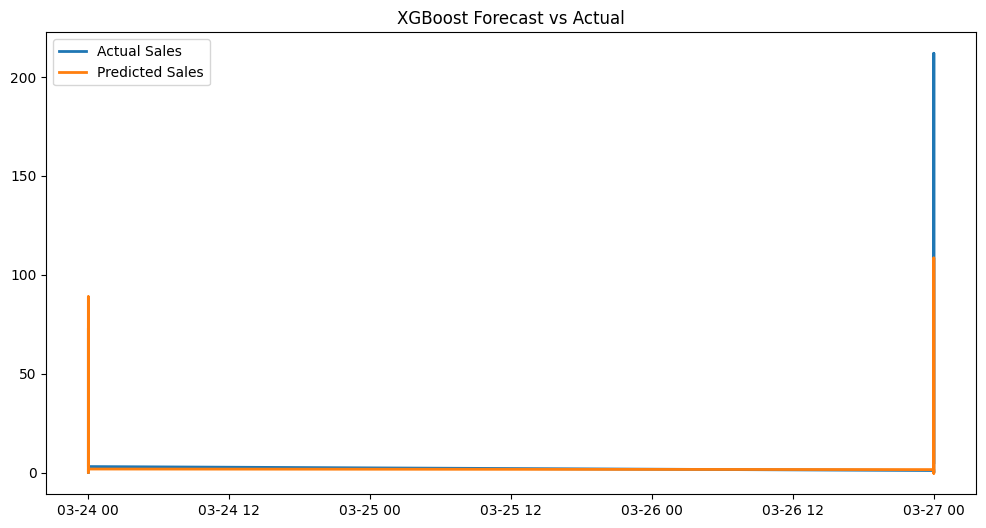

In [26]:
plt.figure(figsize=(12,6))
plt.plot(valid['date'], y_valid.values, label="Actual Sales", linewidth=2)
plt.plot(valid['date'], xgb_preds, label="Predicted Sales", linewidth=2)
plt.legend()
plt.title("XGBoost Forecast vs Actual")
plt.show()


In [39]:
elasticity_data = merged_data[(merged_data['sales'] > 0) & (merged_data['sell_price'] > 0)].copy()
elasticity_data['log_sales'] = np.log(elasticity_data['sales'])
elasticity_data['log_price'] = np.log(elasticity_data['sell_price'])

X = elasticity_data[['log_price']]
y = elasticity_data['log_sales']

lr = LinearRegression().fit(X, y)
elasticity = lr.coef_[0]
print(f"Estimated Price Elasticity of Demand: {elasticity:.4f}")


Estimated Price Elasticity of Demand: -0.1450
Optimal Price: 2.77


In [36]:
def revenue(price, base_demand, base_price, elasticity):
    demand = base_demand * (price / base_price)**elasticity
    return -(price * demand)  # Negative for minimization

base_price = 10
base_demand = 100  # hypothetical

result = minimize_scalar(
    revenue, bounds=(5, 20),
    args=(base_demand, base_price, elasticity),
    method='bounded'
)

optimal_price = round(result.x, 2)
print("Optimal Price:", optimal_price)


Optimal Price: 20.0


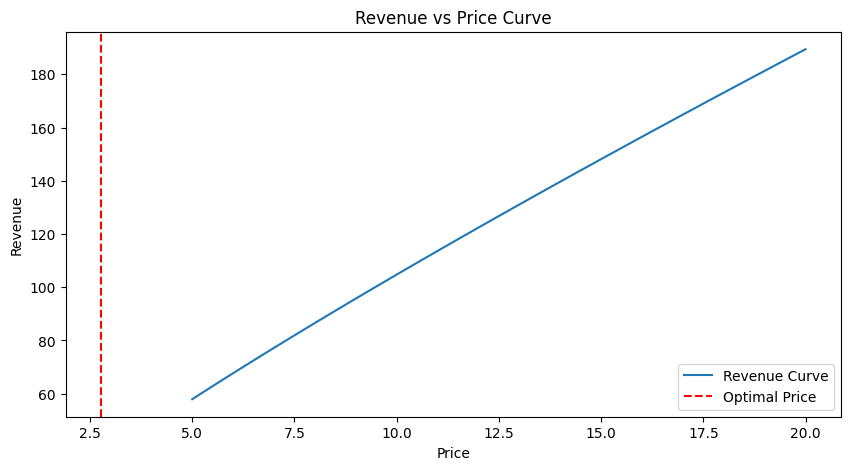

In [41]:
price_range = np.linspace(5, 20, 50)
revenues = [-revenue(p, base_demand, base_price, elasticity) for p in price_range]

plt.figure(figsize=(10,5))
plt.plot(price_range, revenues, label="Revenue Curve")
plt.axvline(optimal_price, color='red', linestyle='--', label='Optimal Price')
plt.xlabel("Price")
plt.ylabel("Revenue")
plt.title("Revenue vs Price Curve")
plt.legend()
plt.show()


In [30]:
# Save trained XGBoost model
joblib.dump(xgb_model, "xgboost_forecasting_model.pkl")

# Save processed dataset
merged_data.to_csv("final_dataset.csv", index=False)

print("Artifacts saved successfully! ✅")


Artifacts saved successfully! ✅


In [38]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

print(f"MAPE: {mape(y_valid.values, xgb_preds):.2f}%")


MAPE: 4110830561.42%
